In [1]:
import time, os

# Numpy
import numpy as np
import scipy
import sklearn
import pandas as pd

# Tensorflow and keras layers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense,\
                                    Activation, ZeroPadding2D,\
                                    BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D,\
                                    Dropout, GlobalMaxPooling2D,\
                                    GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import activations
from tensorflow.keras import backend
from tensorflow.keras import layers

# To generate GIFs


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL

from datetime import datetime

from tqdm.auto import tqdm

import IPython
from IPython import display
import ipywidgets as widgets

import ngraph_bridge
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.python.tools import freeze_graph
import json

from numpy.random import seed
from tensorflow import set_random_seed
from function_approximations import *
def reset_seed():
    # Making results reproducible
    seed(10092)
    set_random_seed(10093)  

/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/he-transformer/build/ext_ngraph_tf/src/ext_ngraph_tf/build_cmake/venv-tf-py3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wi

# Auxiliary Code

In [2]:
def create_dir(dirname):
    try:
        # Create target Directory
        os.mkdir(dirname)
        #print("dirname " , filename ,  " Created ") 
    except FileExistsError:
        print("Directory " , dirname ,  " already exists")

create_dir('models')

def preprocess_real_samples(samples):
    samples = samples.astype('float32').reshape(-1, 28, 28, 1)
    samples = (samples - samples.min()) / (samples.max() - samples.min())
    return samples


def plot_4_by_4_images(x, save = False, savefile="img.png"):
    w=10
    h=10
    fig=plt.figure(figsize=(w, h))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = np.random.randint(x.shape[0])
        fig.add_subplot(rows, columns, i)
        plt.imshow(x[i - 1, :, :, 0], cmap='gray')
    if save:
        plt.savefig(savefile)
    plt.show()
    plt.close()


def plot_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.close()
    
def generate_noise_samples(n=1):
    noise = np.random.normal(0, 1, (n, 100))
    return noise


def generate_fake_samples(generator, n=1):
    noise = generate_noise_samples(n)
    X = generator.predict(noise)
    return X


def generate_and_save_images(generator, noise_test, epoch, filename):
    display.clear_output(wait=True)
    fake_images = generator.predict(noise_test)
    plot_4_by_4_images(fake_images, save=True, savefile='models/{}/img/{:04d}.png'.format(filename, epoch))

    
def train_step(generator, discriminator, gan, real_images, batch_size=64):
    real_label = np.ones((batch_size, 1))
    generated_images = generate_fake_samples(generator, batch_size)
    generated_labels = np.zeros((batch_size, 1))

    X_dis = np.concatenate([real_images, generated_images])
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size]=0.9
        
    discriminator.trainable = True
    discriminator.train_on_batch(X_dis, y_dis)
    #discriminator.train_on_batch(x_fake, y_fake)
        
    discriminator.trainable = False
    x_gan = generate_noise_samples(batch_size)
    y_gan = np.ones((batch_size, 1)) # We assume that we wanted true as answer from the discriminator
    gan.train_on_batch(x_gan, y_gan)

def gen_csv(data_list, filename):
    pd.DataFrame(data_list, 
                 columns =['Epoch', 'Time (s)']).to_csv ('models/%s/times.csv'%(filename), index = False, header=True)

def train(generator, discriminator, gan, dataset, epochs=50, batch_size=64, filename=str(int(time.time())), clear=False):
    m = dataset.shape[0]
    # We check for the number of epochs the NN trained already for
    trained_epochs = len(os.listdir('models/%s/img' % (filename))) if clear == True else 0
    m_batch = m // batch_size
    noise_test = np.random.normal(0,1, [20, 100]) 
    toc = time.time()
    time_data = []
    for epoch in range(epochs):
        tic = time.time()
        for batch_num in range(m_batch):
            tuc = time.time()
                #if batch_num % 30 == 0:
                #print ('[{}%] Time for epoch {} is {} sec'.format((batch_num / m_batch) 
                #* 100,epoch + 1, time.time()-tic), end='\r')
                #generate_and_save_images(noise_test, epoch, batch_num)
            print("[%0.2f%%] Time for epoch %d is %f sec" % ( (batch_num / m_batch) * 100, epoch + 1, time.time()-tic), end='\r')
            
            batch_slot = batch_size * batch_num
            batch = dataset[batch_slot: batch_slot + batch_size]
            train_step(generator, discriminator, gan, batch, batch_size)
        time_data.append((epoch + 1, time.time()-tic))
        generate_and_save_images(generator, noise_test, epoch, filename)
        print ('Time for epoch {} is {} sec'.format(trained_epochs + epoch + 1, time_data[-1][1]))
    
    gen_csv(time_data, filename)
    generator.save('models/%s/generator.h5' % (filename))
    discriminator.save('models/%s/discriminator.h5' % (filename))
    gan.save('models/%s/gan.h5' % (filename))

    
def make_gif(anim_file, file_regex):
    #anim_file = 'dcgan.gif'
    fname = None
    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = glob.glob(file_regex)
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.75)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

        
def format_filename(filename):
    date = datetime.now()
    date_str = "_%02d_%02d_%02d_%02d_%02d" % (date.day, date.month, date.year, date.hour, date.minute)
    create_dir('models/'+ filename)
    create_dir('models/'+ filename +"/img")
    return filename

def plot_vs(x, ys, errors, title):
    fig=plt.figure(figsize=(10, 8))
    Y = ys[0]
    for y in ys:
        plt.plot(X, y[0], label=y[1])

    for y in ys[1:]:
        plt.plot(X, np.abs(Y[0] - y[0]), label='Error %s vs %s' % (Y[1], y[1]), color='crimson')
    plt.xlabel(title)
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.close()
    
def showplots(f,approxlist,a,b, names=None):
    names = ["Original"] + ["Approx. %d" % (i) for i in range(len(approxlist))] if names is None else names
    
    x = np.linspace(a,b,1000)
    plt.figure(1, figsize=(10, 8))
    plt.subplot(211)
    
    vfuncs = [np.vectorize(approx) for approx in approxlist]
    for i, vf in enumerate(vfuncs):
        plt.plot(x,vf(x), label=names[i + 1])
    plt.plot(x,f(x), label=names[0])
    plt.xlim(a,b)
    plt.ylabel('f(x) and approximations fa(x)')

    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.subplot(212)
    for i, vf in enumerate(vfuncs):
        plt.plot(x,f(x)-vf(x), label=names[i + 1] + " Error")
    plt.xlim(a,b)
    plt.ylabel('error = f(x)-fa(x)')
    plt.xlabel('x')
    plt.axhline(y=0, color='k', linestyle=':', linewidth=1)
    plt.axvline(x=0, color='k', linestyle=':', linewidth=1)
    plt.legend()
    plt.show()
    plt.close()
    
def get_elapsed_time(tic):
    elapsed = time.time() - tic
    mins, secs = int(elapsed / 60), elapsed % 60
    hours, mins = int(mins / 60), mins % 60
    return "[%d HOURS, %02d MINS, %02d SECS]" % (hours, mins, secs)


Directory  models  already exists


# Code for Intel nGraph HE Transformer

In [3]:
def print_nodes(graph_def=None):
    """Prints the node names of a graph_def.
        If graph_def is not provided, use default graph_def"""

    if graph_def is None:
        nodes = [n.name for n in tf.get_default_graph().as_graph_def().node]
    else:
        nodes = [n.name for n in graph_def.node]

    print("nodes", nodes)

# https://www.dlology.com/blog/how-to-convert-trained-keras-model-to-tensorflow-and-make-prediction/
def freeze_session(session,
                   keep_var_names=None,
                   output_names=None,
                   clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import (
        convert_variables_to_constants,
        remove_training_nodes,
    )

    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(
            set(v.op.name for v in tf.global_variables()).difference(
                keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        #print_nodes(input_graph_def)
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        frozen_graph = remove_training_nodes(frozen_graph)
        return frozen_graph

def save_model(sess, output_names, directory, filename):
    frozen_graph = freeze_session(sess, output_names=output_names)
    #print_nodes(frozen_graph)
    tf.io.write_graph(frozen_graph, directory, filename + ".pb", as_text=False)
    print("Model saved to: %s" % filename + ".pb")

    
def load_pb_file(filename):
    """"Returns the graph_def from a saved protobuf file"""
    if not os.path.isfile(filename):
        raise Exception("File, " + filename + " does not exist")

    with tf.io.gfile.GFile(filename, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())

    print("Model restored")
    return graph_def

In [4]:
def get_N(total_coefficient_modulus_bit_width, security_level, sec_type='classical'):
    sec = {
        'classical':{
            128:{
                1024:  27,
                2048:  54,
                4096:  109,
                8192:  218,
                16384: 438,
                32768: 881
            },
            192:{
                1024:  19,
                2048:  37,
                4096:  75,
                8192:  152,
                16384: 305,
                32768: 611
            },
            256:{
                1024:  14,
                2048:  29,
                4096:  58,
                8192:  118,
                16384: 237,
                32768: 476
            }
        },
        'quantum':{
           128:{
                1024:  25,
                2048:  51,
                4096:  101,
                8192:  202,
                16384: 411,
                32768: 827
            },
            192:{
                1024:  17,
                2048:  35,
                4096:  70,
                8192:  141,
                16384: 284,
                32768: 571
            },
            256:{
                1024:  13,
                2048:  27,
                4096:  54,
                8192:  109,
                16384: 220,
                32768: 443
            }
        }
    }
    log2q_prev = 0
    for n, log2q in sec[sec_type][security_level].items():
        if log2q_prev < total_coefficient_modulus_bit_width < log2q:
            return n
        log2q_prev = log2q
    return n

def define_encryption_params(security_level, L):
    # Select the security level
    # Compute the multiplicative depth of the computational graph
    #L = 8 # Assumed from configuration
    # Estimate the bit-precission s, required. According to Intel, the best tradeoff is ~24 bits
    s = 24
    # Choose the coeff_modulus = [s, s, s, ..., s]. A list of L coefficient moduli, each with s bits. Set the scale to s.
    coeff_modulus = [s] * L
    coeff_modulus[0] = 30
    coeff_modulus[-1] = 30
    scale = s
    # Compute the total coefficient modulus bit width, L * s in the above parameter selection.
    total_coefficient_modulus_bit_width = L * s
    # Set the poly_modulus_degree to the smallest power of two, with coefficient modulus smaller than the maximum allowed.
    # Based on the table of recommended parameters. 
    N = get_N(total_coefficient_modulus_bit_width, security_level)
    poly_modulus_degree = N
    # For best performance, we should choose the batch_size to max_batch_size
    max_batch_size = poly_modulus_degree / 2
    # We should only include the complex packing if there are polynomial activations.
    # That is, if we make use of our own activation functions
    complex_packing = False
    
    enc_params = {
        'scheme_name': 'HE_SEAL',          # Fixed, to use the HE backend
        'poly_modulus_degree': poly_modulus_degree,       # A power of 2 {1024, 2048, 4096, 8192, 16384}
        'security_level': security_level,             # The security we want to ensure {0, 128, 192, 256}
        'coeff_modulus': coeff_modulus, # A number inbetween 1 and 60
        'scale': 2 ** s,                  # The fixed bit precission of the encoding. (log2(scale) is the number of bits)
        'complex_packing': complex_packing,
    }
    print(enc_params)
    return enc_params
def gen_json_params_file(filename, security_level=128, L=8):
    enc_params_dict = define_encryption_params(security_level, L)
    enc_params_json = json.dumps(enc_params_dict)
    with open(filename, 'w+') as file:
        file.write(enc_params_json)
    print("Generated configuration in %s" %(filename))
    
gen_json_params_file('config.json', security_level=128, L=4)

"""python test.py --batch_size=100 \
               --backend=HE_SEAL \
               --model_file=models/cryptonets.pb \
               --encrypt_server_data=true \
               --encryption_parameters=$HE_TRANSFORMER/configs/he_seal_ckks_config_N13_L8.json
"""
def get_config_for_ngraph_server(tensor_param_name):
    rewriter_options = rewriter_config_pb2.RewriterConfig()
    rewriter_options.meta_optimizer_iterations = rewriter_config_pb2.RewriterConfig.ONE
    rewriter_options.min_graph_nodes = -1
    server_config = rewriter_options.custom_optimizers.add()
    server_config.name = "ngraph-optimizer"
    server_config.parameter_map["ngraph_backend"].s = b'HE_SEAL'
    server_config.parameter_map["device_id"].s = b""
    server_config.parameter_map["encryption_parameters"].s = b'config.json'
    server_config.parameter_map["enable_client"].s = b'false'
    # Only server
    server_config.parameter_map[tensor_param_name].s = b"encrypt"
    # With client
    #server_config.parameter_map[tensor_param_name].s = b"client_input"
    # Pack data
    server_config.parameter_map[tensor_param_name].s += b",packed"

    config = tf.compat.v1.ConfigProto()
    config.MergeFrom(
            tf.compat.v1.ConfigProto(
                graph_options=tf.compat.v1.GraphOptions(
                    rewrite_options=rewriter_options)))
    return config

{'scheme_name': 'HE_SEAL', 'poly_modulus_degree': 4096, 'security_level': 128, 'coeff_modulus': [30, 24, 24, 30], 'scale': 16777216, 'complex_packing': False}
Generated configuration in config.json


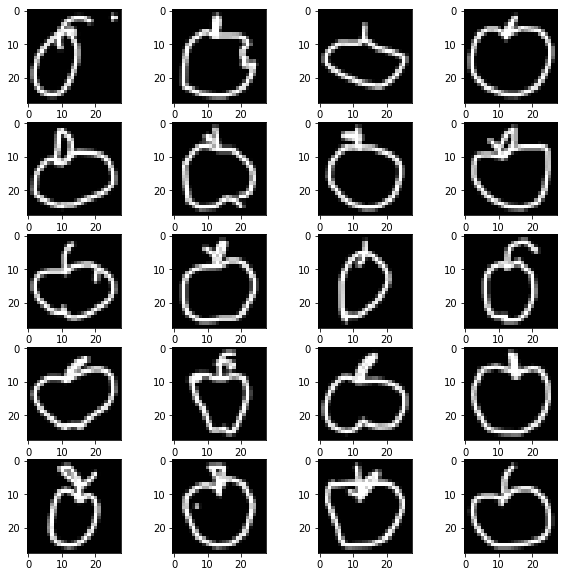

In [5]:
plot_4_by_4_images(preprocess_real_samples(np.load('apple.npy')))

# Private inference

In [6]:
def my_event_handler(btn_object):

    # Clear output and select a new model.
    display.clear_output(wait=True)
    display_models()
    model = btn_object.description
    print("Loading %s model..." % (model), end='\r')
    
    custom_functions = {'relu_regression_2': relu_regression_2,
                        'relu_regression_15': relu_regression_15,
                        'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    generator = tf.keras.models.load_model('models/%s/generator.h5' % (model), 
                                           custom_objects=custom_functions)
    discriminator = tf.keras.models.load_model('models/%s/discriminator.h5' % (model), 
                                           custom_objects=custom_functions)
    print("Loaded %s model    " % (model))
    print_intermediate_steps(generator, noise, (4, 10))
    
    print_intermediate_steps(discriminator, real_dataset[3:10], (0, 8))
    


def display_models():
    print("Click on a model to execute it on a private input:")
    dirs = os.listdir( 'models/' )
    for d in dirs:
        btn = widgets.Button(description=d)
        btn.on_click(my_event_handler)
        display.display(btn)
        
display_models()  

Click on a model to execute it on a private input:


Button(description='basic_1', style=ButtonStyle())

Button(description='relu_regression_15', style=ButtonStyle())

Button(description='relu_regression_2', style=ButtonStyle())

Button(description='square', style=ButtonStyle())

Button(description='square2', style=ButtonStyle())

Button(description='square_simple', style=ButtonStyle())

Button(description='taylor_sigmoid', style=ButtonStyle())

Button(description='v2_base', style=ButtonStyle())

Button(description='v2_chebyshev_integral_relu', style=ButtonStyle())

Button(description='v2_chebyshev_relu', style=ButtonStyle())

Button(description='v2_chebyshev_sigmoid', style=ButtonStyle())

Button(description='v2_chebyshev_tanh', style=ButtonStyle())

Button(description='v2_square', style=ButtonStyle())

Button(description='v2_taylor_relu', style=ButtonStyle())

Button(description='v2_taylor_sigmoid', style=ButtonStyle())

Button(description='v2_taylor_tanh', style=ButtonStyle())

In [ ]:
def private_pred(model, x):
    custom_functions = {'relu_regression_2': relu_regression_2,
                        'relu_regression_15': relu_regression_15,
                        'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    generator = tf.keras.models.load_model('models/%s/generator.h5' % (model), 
                                           custom_objects=custom_functions)
    print("Loaded %s model    " % (model))
        # Save model as PB
    save_model(tf.compat.v1.keras.backend.get_session(), 
               ["output_gen/conv2d_transpose"], "./models/%s/"%(model), 
               model)

    
    # Reset again the default graph
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)

    
    tf.import_graph_def(load_pb_file("./models/%s/%s.pb"%(model, model)))  
    
    x_input = tf.compat.v1.get_default_graph().get_tensor_by_name('import/input_gen_input:0')
    y_output = tf.compat.v1.get_default_graph().get_tensor_by_name('import/output_gen/conv2d_transpose:0')
    print_nodes()
    config = get_config_for_ngraph_server(x_input.name)
    with tf.compat.v1.Session(config=config) as sess:
        print("Executing new comp")
        sess.run(tf.compat.v1.global_variables_initializer())
        start_time = time.time()
        y_hat = y_output.eval(feed_dict={x_input: x })
        y_pred = np.tanh(y_hat)
        elasped_time = time.time() - start_time
        print("Total time(s)", np.round(elasped_time, 3))
        return y_pred

    
def private_pred2(model, x):
    custom_functions = {'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    discriminator = tf.keras.models.load_model('models/%s/discriminator.h5' % (model), 
                                           custom_objects=custom_functions)
    #print_nodes()
    print("Loaded %s model    " % (model))
        # Save model as PB
    save_model(tf.compat.v1.keras.backend.get_session(), 
               ["output_disc/BiasAdd"], "./models/%s/"%(model), 
               model)

    
    # Reset again the default graph
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)

    
    tf.import_graph_def(load_pb_file("./models/%s/%s.pb"%(model, model)))  
    
    x_input = tf.compat.v1.get_default_graph().get_tensor_by_name('import/input_disc_input:0')
    y_output = tf.compat.v1.get_default_graph().get_tensor_by_name('import/output_disc/BiasAdd:0')
    print_nodes()
    config = get_config_for_ngraph_server(x_input.name)
    with tf.compat.v1.Session(config=config) as sess:
        print("Executing new comp")
        sess.run(tf.compat.v1.global_variables_initializer())
        start_time = time.time()
        y_hat = y_output.eval(feed_dict={x_input: x })
        y_pred = np.tanh(y_hat)
        elasped_time = time.time() - start_time
        print("Total time(s)", np.round(elasped_time, 3))
        return y_pred
y_pred = private_pred2('square2', np.random.normal(0, 1, [1, 28, 28, 1]))    

Loaded square2 model    
Model saved to: square2.pb
Model restored
nodes ['import/input_disc_input', 'import/input_disc/kernel', 'import/input_disc/bias', 'import/input_disc/Conv2D', 'import/input_disc/BiasAdd', 'import/activation_8/mul', 'import/conv2d_1/kernel', 'import/conv2d_1/bias', 'import/conv2d_1/Conv2D', 'import/conv2d_1/BiasAdd', 'import/activation_9/mul', 'import/flatten_1/Shape', 'import/flatten_1/strided_slice/stack', 'import/flatten_1/strided_slice/stack_1', 'import/flatten_1/strided_slice/stack_2', 'import/flatten_1/strided_slice', 'import/flatten_1/Reshape/shape/1', 'import/flatten_1/Reshape/shape', 'import/flatten_1/Reshape', 'import/output_disc/kernel', 'import/output_disc/bias', 'import/output_disc/MatMul', 'import/output_disc/BiasAdd', 'import/SGD/iter', 'import/SGD/decay', 'import/SGD/learning_rate', 'import/SGD/momentum']
Executing new comp


In [ ]:
%%time
y_pred = private_pred2('square2', np.random.normal(0, 1, [1, 28, 28, 1]))    

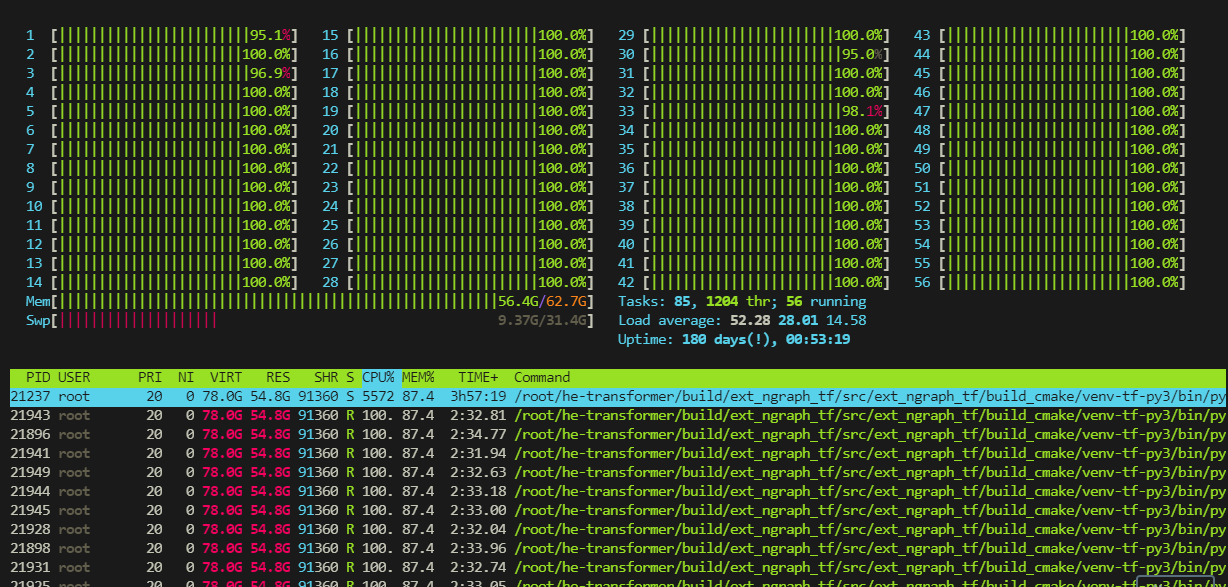

In [ ]:
def my_event_handler(btn_object):

    # Clear output and select a new model.
    display.clear_output(wait=True)
    display_models()
    model = btn_object.description
    print("Loading %s model..." % (model), end='\r')
    
    custom_functions = {'relu_regression_2': relu_regression_2,
                        'relu_regression_15': relu_regression_15,
                        'taylor_sigmoid': taylor_sigmoid,
                        'square_activation': square_activation}
    # Reset the graph and backend learning phase.
    tf.reset_default_graph()
    tf.keras.backend.set_learning_phase(0)
    
    # Load generator as H5
    generator = tf.keras.models.load_model('models/%s/generator.h5' % (model), 
                                           custom_objects=custom_functions)
    discriminator = tf.keras.models.load_model('models/%s/discriminator.h5' % (model), 
                                           custom_objects=custom_functions)
    print("Loaded %s model    " % (model))
    print_intermediate_steps(generator, noise, (4, 10))
    
    print_intermediate_steps(discriminator, real_dataset[3:10], (0, 8))
    


def display_models():
    print("Click on a model to execute it on a private input:")
    dirs = os.listdir( 'models/' )
    for d in dirs:
        btn = widgets.Button(description=d)
        btn.on_click(my_event_handler)
        display.display(btn)
        
display_models()   